# Phising Email Sentiment Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from transformers import AutoTokenizer

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from tensorflow.keras.layers import Dense, Bidirectional, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Functions

In [2]:
def check_for_nulls_dupes(df):
  print(f"Amount of Null Values: {df.isna().sum()}")
  print(f"Amount of Dupe Values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.show()
  
  plt.figure(figsize=(10, 6))
  plt.title("Target Class Breakdown")
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_stop(words):
  word_tokens = " ".join(word_tokenize(words))
  filtered_tokens = re.sub(r'[^a-zA-Z\s]', "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_tokens if not w.lower().strip() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def grouped_insights(df, cols, x, metric_name):
  
  for col in cols:
    plt.figure(figsize=(10, 6))
    grouped_df = df.groupby(x)[col].sum().reset_index() if metric_name == "sum" else df.groupby(x)[col].mean().reset_index()
    sns.barplot(data=grouped_df, x=x, y =col, hue=col)
    plt.xlabel(x)
    plt.ylabel(metric_name)
    plt.title(f"{x} grouped by: {col} {metric_name}")
    plt.xticks(rotation=45)
  plt.show()
  


# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/phishing_email.csv", nrows=15000)
df

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
14995,urgent update unreported determinant angelenos...,1
14996,buy vlium x anax sa 7 _ 0 ord ering onl ine da...,1
14997,bruceg em ca blowing stock 3 month promotion h...,1
14998,hi fannie allen write accepting mortgage appli...,1


# Check for Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

Amount of Null Values: text_combined    0
label            0
dtype: int64
Amount of Dupe Values: 315


In [5]:
df.drop_duplicates(inplace=True)

# Check For Class Imbalance

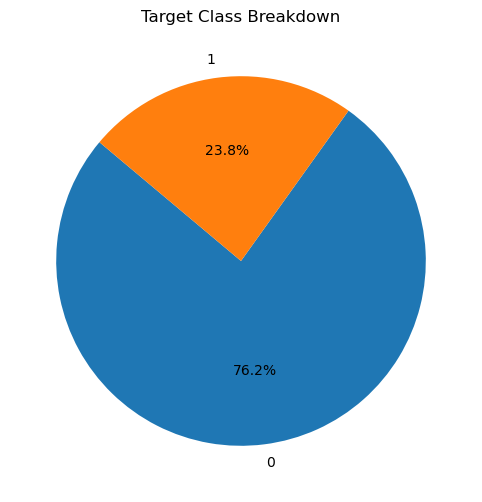

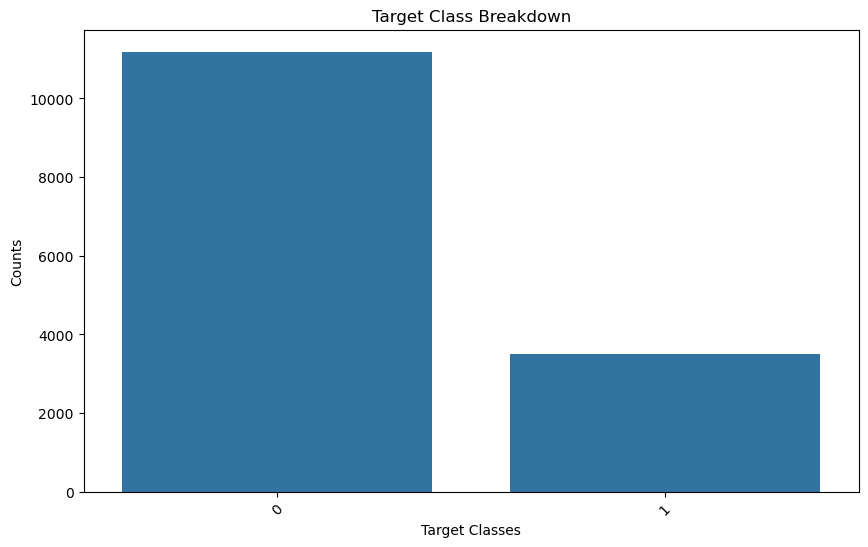

In [6]:
check_class_imbalance(df["label"])

# Balanced Class means our model can generalize more accurately on unseen data.

# Data Visuals

In [7]:
df["len_review"] = df["text_combined"].apply(lambda review: len(review))
df["word_count"] = df["text_combined"].apply(lambda review: len(review.split(" ")))

In [8]:
df.describe()

,label,len_review,word_count
count,14685.000000,14685.000000,14685.000000
mean,0.237726,1150.891386,174.565271
std,0.425705,3961.889762,576.266594
min,0.000000,1.000000,2.000000
25%,0.000000,243.000000,39.000000
50%,0.000000,517.000000,81.000000
75%,0.000000,1100.000000,172.000000
max,1.000000,160318.000000,23359.000000


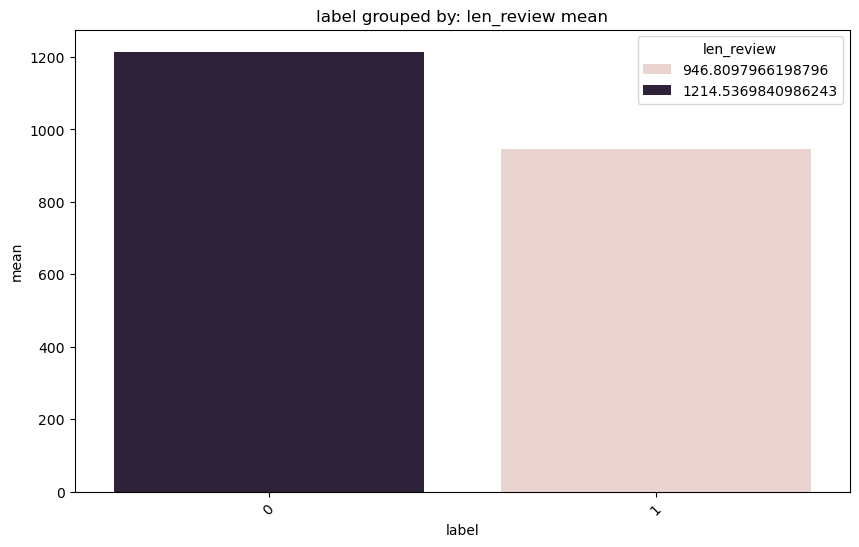

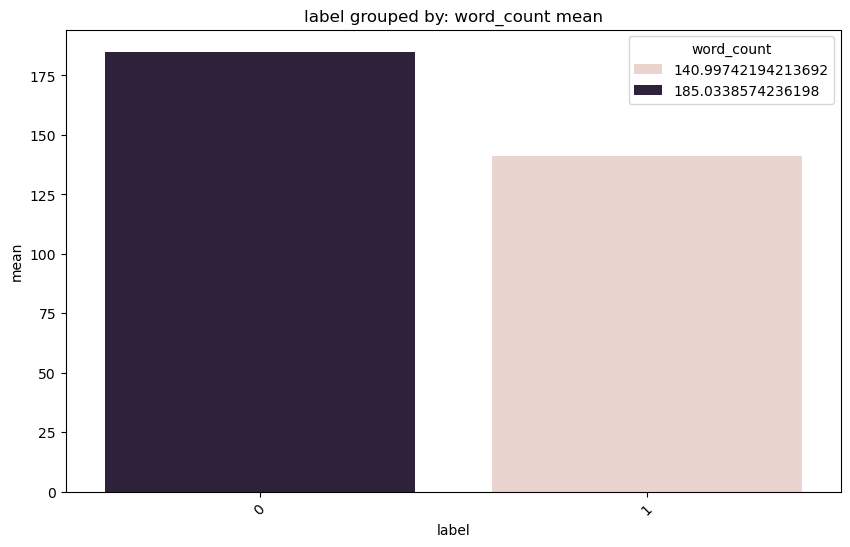

In [9]:
grouped_insights(df, ["len_review", "word_count"], "label", "mean")

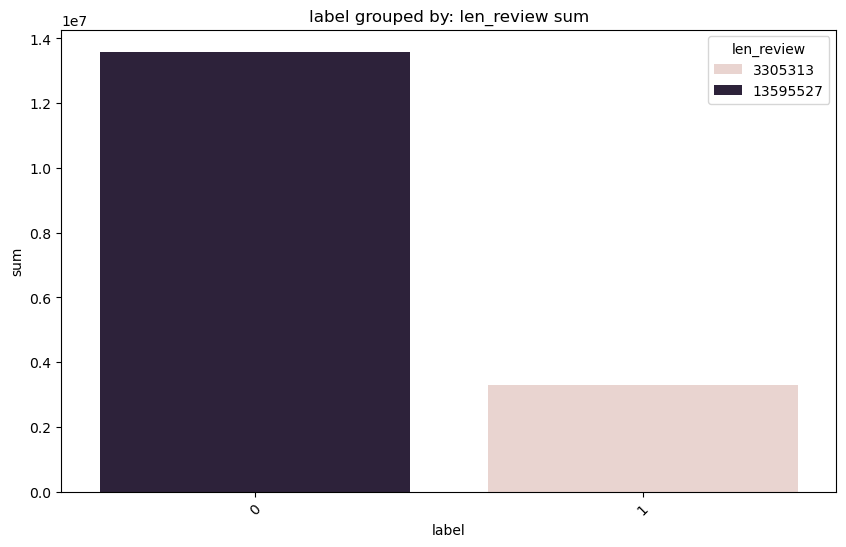

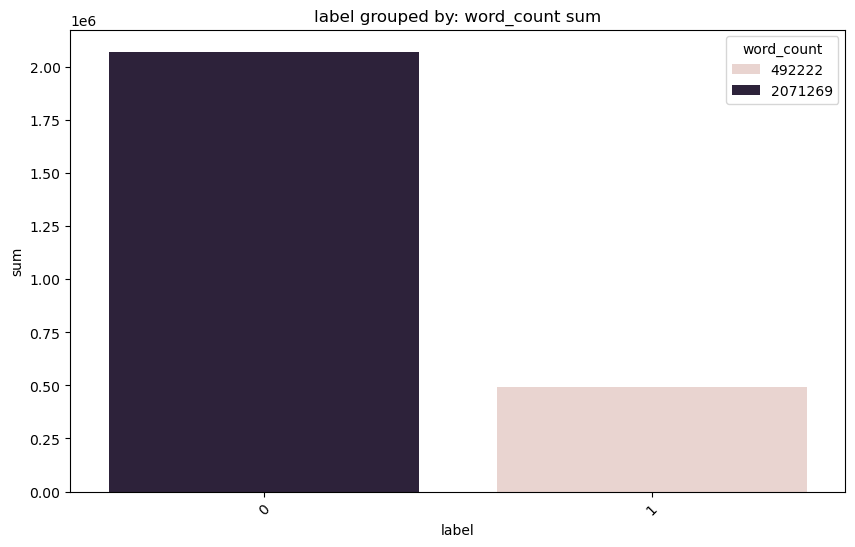

In [10]:
grouped_insights(df, ["len_review", "word_count"], "label", "sum")

# Data Preprocessing

In [11]:
df["text_combined"] = df["text_combined"].apply(remove_stop)

In [12]:
df = df[df["text_combined"] != ""]

# Bert Model

In [13]:
model ="distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

# Separate Feature Variables

In [14]:
X, y = df["text_combined"], df["label"]

In [20]:
seq = [sequence for sequence in X]
model_inputs = tokenizer(seq, max_length=512, truncation=True, padding=True, return_tensors="tf")

In [21]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"], y))

In [22]:
max_index = max([max(seq) for seq in model_inputs["input_ids"] if len(seq) > 0])
print("Maximum index in input data:", max_index)

Maximum index in input data: tf.Tensor(29611, shape=(), dtype=int32)


In [26]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [27]:
len_dataset = len(dataset)

In [28]:
train = dataset.take(int(len_dataset*.7))
test = dataset.skip(int(len_dataset*.7)).take(int(len_dataset*.2))
val = dataset.skip(int(len_dataset*.9)).take(int(len_dataset*.1))

In [29]:
early_stopping = EarlyStopping(
  monitor="val_loss",
  patience=10, 
  min_delta=0.01,
  verbose=0,
  mode="min",
  restore_best_weights=True
)

In [31]:
vocab_size =   max(tokenizer.get_added_vocab().values())+1
model = Sequential()
model.add(Embedding(input_dim=29612, output_dim=32))
model.add(Bidirectional(LSTM(32, activation="tanh")))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          947584    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 512)               131584    
                                                                 
 dense_7 (Dense)             (None, 1)                 513       
                                                      

In [33]:
history = model.fit(
  train,
  epochs=100,
  batch_size=16,
  validation_data=val,
  verbose=0,
  callbacks=[early_stopping]
)